In [ ]:
import os
import json
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.models import resnet18
from torchvision.models import resnet50
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F
from torch.autograd import Variable
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip ./drive/MyDrive/소재.zip -d ./zip_data


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./zip_data/pic_filter/359560.jpg  
  inflating: ./zip_data/pic_filter/359570.jpg  
  inflating: ./zip_data/pic_filter/359730.jpg  
  inflating: ./zip_data/pic_filter/359760.jpg  
  inflating: ./zip_data/pic_filter/360201.jpg  
  inflating: ./zip_data/pic_filter/360230.jpg  
  inflating: ./zip_data/pic_filter/360290.jpg  
  inflating: ./zip_data/pic_filter/360440.jpg  
  inflating: ./zip_data/pic_filter/360480.jpg  
  inflating: ./zip_data/pic_filter/360620.jpg  
  inflating: ./zip_data/pic_filter/360670.jpg  
  inflating: ./zip_data/pic_filter/360780.jpg  
  inflating: ./zip_data/pic_filter/360880.jpg  
  inflating: ./zip_data/pic_filter/360901.jpg  
  inflating: ./zip_data/pic_filter/360970.jpg  
  inflating: ./zip_data/pic_filter/360990.jpg  
  inflating: ./zip_data/pic_filter/361020.jpg  
  inflating: ./zip_data/pic_filter/361030.jpg  
  inflating: ./zip_data/pic_filter/361040.jpg  
  inflating: ./zip_data/pic_filter/361080.jpg  
  in

In [ ]:
zip_dir = "./zip_data"
save_dir = "./drive/MyDrive/laundry_step_ckpoint"

json_dir = "./zip_data/json_filter"
image_dir = "./zip_data/pic_filter"

json_files = []
image_files = []

for train_file in os.listdir(json_dir):
    json_files.append(os.path.join(json_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
# print("json 장르", json_genre)
# print("image 장르", image_genre)

데이터 개수: 18003
이미지 개수: 18003


In [ ]:
# os.mkdir(f"{save_dir}")

In [ ]:
train_image, val_image, train_json, val_json = train_test_split(image_files, json_files, test_size=0.3, random_state=42, shuffle=True)
print(len(train_image), len(val_image))
print(len(train_json), len(val_json))

12602 5401
12602 5401


In [ ]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric

        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        
# train_image_dict.items()
# valid_image_dict

100%|██████████| 5401/5401 [00:00<00:00, 6633.24it/s]


In [ ]:
#사용자 정의 데이터셋
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, transform=None, data_dir=r"./zip_data/pic_filter"): 
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.transform = transform
        self.image_files = []
        self.dict_label_to_num = {
            "메시": 0,"데님" : 0 , "우븐": 0 ,"패딩" : 0,
            "니트":1,"레이스":1,"린넨":1,"플리스":1,"네오프렌":1, "저지":1,"울/캐시미어" :1,"헤어 니트": 1,
            "퍼":2,"코듀로이":2,"실크":2,"스판덱스":2,"트위드":2,"자카드":2 ,"벨벳":2,"시폰":2,
            "스웨이드":3,"시퀸/글리터":3,"가죽":3,"비닐/PVC":3
          
        } #0:물세탁, 1:울세탁, 2:드라이클리닝, 3:기타
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        # im = transforms.Normalize((0.5,),(0.5,))(im) #######
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((150,150))(im) #,Image.BILINEAR
        # transform = transforms.RandomHorizontalFlip(p=1)
        # imgs = transform(im)
        
        # torchvision_transform=transforms.Compose([
        #                                 transforms.RandomHorizontalFlip(),
        #                                 transforms.ToTensor(),
        #                                 transforms.Normalize((0.1307,),(0.3081,))])
        # im = torchvision_transform(im)
        fabric_label = self.dict_label_to_num[fabric]
  
        
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)

torchvision_transform=transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])
torchvision_dataset = ClothDataset(train_image_dict,transform=torchvision_transform)

In [ ]:
# class ClothDataset(Dataset):
#     def __init__(self, train_image_dict, data_dir=r"./zip_data/pic_filter"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
#         super().__init__()
#         self.data_dir = data_dir
#         self.train_image_dict = train_image_dict
#         self.image_files = []
#         self.dict_label_to_num = {
#             "퍼" : 0,
#             "니트" : 1,
#             "무스탕" : 2,
#             "레이스" : 3,
#             "스웨이드" : 4,
#             "린넨" : 5,
#             "앙고라" : 6,
#             "메시" : 7,
#             "코듀로이" : 8,
#             "플리스" : 9,
#             "시퀸/글리터" : 10,
#             "네오프렌" : 11,
#             "데님" : 12,
#             "실크" : 13,
#             "저지" : 14,
#             "스판덱스" : 15,
#             "트위드" : 16,
#             "자카드" : 17,
#             "벨벳" : 18,
#             "가죽" : 19,
#             "비닐/PVC" : 20,
#             "면" : 21,
#             "울/캐시미어" : 22,
#             "시폰" : 23,
#             "합성섬유" : 24,
#             "우븐" : 25,
#             "패딩" : 26,
#             "헤어 니트": 27
#         }
#         self.setup()

#     def setup(self):
#         for (file_name, xy), fabric in self.train_image_dict.items():
#             if not fabric:
#                 continue
#             self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric)) #os.path.join(data_dir+이미지명)/좌표/직물을 list에

#     def __getitem__(self, idx):
#         file_name, xy, fabric = self.image_files[idx]
#         fabric=fabric[0]
#         x, y, w, h = map(int, xy)
# #         
#         im = Image.open(file_name)
#         im = transforms.ToTensor()(im)
#         im = torchvision.transforms.functional.crop(im, y, x, h, w)
#         im = transforms.Resize((150,150))(im)

#         fabric_label = self.dict_label_to_num[fabric]
#         return im, fabric_label
    
#     def __len__(self):
#         return len(self.image_files)



In [ ]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
# print(train_dataset[0][0])
# print(len(torchvision_dataset))
print(len(train_dataset))
print(len(valid_dataset))

19649
8400


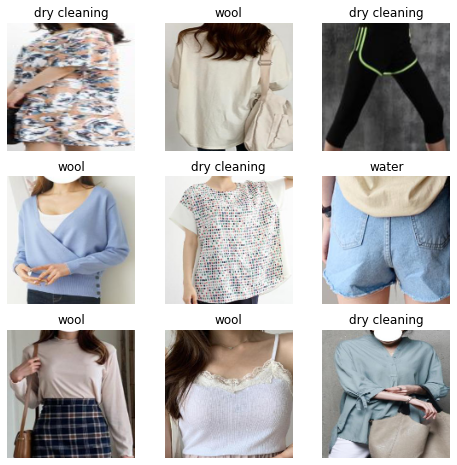

In [ ]:
classes=["water",
        "wool",
        "dry cleaning",
        "etc"] 

# y=train_dataset[18][1] #dict의 18번째 label-->label 값을 뜻한다
figure = plt.figure(figsize=(8,8))
cols, rows= 3,3

for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_dataset),size=(1,)).item()
    
    # img, label= train_dataset[sample_idx]
    img, label= torchvision_dataset[sample_idx]

    figure.add_subplot(rows, cols, i)
    title=classes[label]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

11717


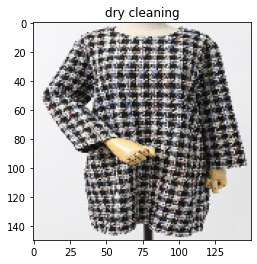

In [ ]:
idx = np.random.randint(0, len(train_dataset))
print(idx)
title=classes[train_dataset[idx][1]]
plt.title(title)
plt.imshow(train_dataset[idx][0].permute(1,2,0))

In [ ]:
# import torch.nn.functional as F

# class efficientnet_b6(nn.Module): #Resnet50
#     def __init__(self, num_classes):
#         super().__init__()
#         self.model = torchvision.models.efficientnet_b6(pretrained=True) #50
        

#         self.fc = nn.Linear(1000, num_classes) #1000
        
#     def forward(self, x):
#         x = self.model(x)
#         return self.fc(x)


In [ ]:
class Resnet50(nn.Module): #Resnet50
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True) #50
        

        self.fc = nn.Linear(1000, num_classes) #1000
        # self.dropout=nn.Dropout(0.25) #############
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [ ]:
# class Net(nn.Module):
#     def __Init__(self, input_shape=(3,32,32)):
#         super(Net, self).__init__()

#         self.conv1=nn.Conv2d(3,32,3)
#         self.conv2=nn.Conv2d(32,64,3)
#         self.conv3=nn.Conv2d(64,128,3)

#         self.pool=nn.MaxPool2d(2,2)

#         n_size=self._get_conv_output(input_shape)

#         self.fc1=nn.Linear(n_size,512)
#         self.fc2=nn.Linear(512,10)

#         self.dropout=nn.Dropout(0.25)

#     def dorward(self,x):
#         x=self._forward_features(x)
#         x=x.view(x.size(0),-1)
#         x=self.dropout(x)
#         x=F.relu(self.fc1(x))

#         x=self.dropout(x)
#         x=self.fc2(x)
#         return x


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #,long
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
BATCH_SIZE = 128 #32 작은 것보다 오히려 큰게 나을수도
EPOCHS =10
LOG_INTERVAL=30 #35
LEARNING_RATE=0.001 #0.001
# SAVE_DIR="./results"
torch.cuda.empty_cache()
device=torch.device("cuda") # if torch.cuda.is_available() else "cpu"

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
# train_loader=DataLoader(torchvision_dataset,  batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

# model = efficientnet_b6(num_classes=4).cuda() #gpu
model = Resnet50(num_classes=4).cuda() #gpu

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1) #1e-5
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5) #0.5
best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)    

        # l2_lambda = 0.001
        # l2_norm = sum(p.pow(2.0).sum()
        #           for p in model.parameters())
        # loss = FocalLoss(gamma=2)(outs,labels)
        loss = criterion(outs, labels)
        # loss = loss+l2_lambda*l2_norm

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            torch.save(model.state_dict(), f"{save_dir}/{idx}.pth")
            loss_value = 0
            matches = 0
    scheduler.step()
    
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() #검증 모드,검증 목적은 최적의 epoch를 찾아 overfiting과 unseen data 문제 를 막는 것
        val_loss_items=[]
        val_acc_items=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            num_label=labels.tolist()     #😊
            num_pred=preds.tolist() 


            # loss_item = FocalLoss(gamma=2)(outs,labels).item()
            loss_item = criterion(outs, labels).item()
            
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)
        
        print(classification_report(num_label, num_pred, target_names=['class 0', 'class 1', 'class 2','class 3']))

        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            torch.save(model.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        
        torch.save(model.state_dict(),f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

 19%|█▉        | 29/153 [01:01<04:22,  2.12s/it]

Epoch[0/10](30/153) || training loss 1.165 || training accuracy 52.97%


 39%|███▊      | 59/153 [02:05<03:19,  2.12s/it]

Epoch[0/10](60/153) || training loss 0.869 || training accuracy 64.19%


 58%|█████▊    | 89/153 [03:09<02:18,  2.16s/it]

Epoch[0/10](90/153) || training loss 0.8387 || training accuracy 64.64%


 78%|███████▊  | 119/153 [04:14<01:13,  2.15s/it]

Epoch[0/10](120/153) || training loss 0.8269 || training accuracy 64.61%


 97%|█████████▋| 149/153 [05:17<00:08,  2.14s/it]

Epoch[0/10](150/153) || training loss 0.7941 || training accuracy 67.08%


100%|██████████| 153/153 [05:26<00:00,  2.13s/it]


Calculating validation results...


100%|██████████| 65/65 [02:00<00:00,  1.86s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.72      0.51      0.60        45
     class 1       0.59      0.86      0.70        59
     class 2       0.44      0.17      0.24        24
     class 3       0.00      0.00      0.00         0

    accuracy                           0.61       128
   macro avg       0.44      0.39      0.39       128
weighted avg       0.61      0.61      0.58       128

New best model for val accuracy : 64.93%! saving the best model..
[Val] acc : 64.93%, loss: 0.89 || best acc : 64.93%, best loss: 0.89


 19%|█▉        | 29/153 [01:01<04:25,  2.14s/it]

Epoch[1/10](30/153) || training loss 0.6574 || training accuracy 73.07%


 39%|███▊      | 59/153 [02:06<03:20,  2.13s/it]

Epoch[1/10](60/153) || training loss 0.6434 || training accuracy 73.57%


 58%|█████▊    | 89/153 [03:10<02:16,  2.13s/it]

Epoch[1/10](90/153) || training loss 0.6595 || training accuracy 72.86%


 78%|███████▊  | 119/153 [04:14<01:11,  2.10s/it]

Epoch[1/10](120/153) || training loss 0.6264 || training accuracy 74.97%


 97%|█████████▋| 149/153 [05:18<00:08,  2.14s/it]

Epoch[1/10](150/153) || training loss 0.6334 || training accuracy 74.11%


100%|██████████| 153/153 [05:27<00:00,  2.14s/it]


Calculating validation results...


100%|██████████| 65/65 [02:00<00:00,  1.86s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.69      0.71      0.70        52
     class 1       0.63      0.72      0.67        43
     class 2       0.76      0.68      0.72        28
     class 3       0.00      0.00      0.00         5

    accuracy                           0.68       128
   macro avg       0.52      0.53      0.52       128
weighted avg       0.66      0.68      0.67       128

New best model for val accuracy : 65.27%! saving the best model..
[Val] acc : 65.27%, loss:  0.8 || best acc : 65.27%, best loss:  0.8


 19%|█▉        | 29/153 [01:01<04:20,  2.10s/it]

Epoch[2/10](30/153) || training loss 0.5377 || training accuracy 79.14%


 39%|███▊      | 59/153 [02:05<03:18,  2.11s/it]

Epoch[2/10](60/153) || training loss 0.4964 || training accuracy 81.17%


 58%|█████▊    | 89/153 [03:09<02:16,  2.13s/it]

Epoch[2/10](90/153) || training loss 0.5004 || training accuracy 80.68%


 78%|███████▊  | 119/153 [04:14<01:13,  2.16s/it]

Epoch[2/10](120/153) || training loss 0.5335 || training accuracy 78.65%


 97%|█████████▋| 149/153 [05:18<00:08,  2.09s/it]

Epoch[2/10](150/153) || training loss 0.5069 || training accuracy 79.53%


100%|██████████| 153/153 [05:27<00:00,  2.14s/it]


Calculating validation results...


100%|██████████| 65/65 [02:01<00:00,  1.86s/it]


              precision    recall  f1-score   support

     class 0       0.70      0.63      0.67        41
     class 1       0.69      0.75      0.72        61
     class 2       0.52      0.52      0.52        23
     class 3       1.00      0.33      0.50         3

    accuracy                           0.66       128
   macro avg       0.73      0.56      0.60       128
weighted avg       0.67      0.66      0.66       128

New best model for val accuracy : 67.46%! saving the best model..
[Val] acc : 67.46%, loss: 0.81 || best acc : 67.46%, best loss:  0.8


 19%|█▉        | 29/153 [01:01<04:24,  2.13s/it]

Epoch[3/10](30/153) || training loss 0.4447 || training accuracy 83.93%


 39%|███▊      | 59/153 [02:05<03:22,  2.15s/it]

Epoch[3/10](60/153) || training loss 0.4292 || training accuracy 83.36%


 58%|█████▊    | 89/153 [03:10<02:16,  2.13s/it]

Epoch[3/10](90/153) || training loss 0.443 || training accuracy 83.33%


 78%|███████▊  | 119/153 [04:14<01:12,  2.12s/it]

Epoch[3/10](120/153) || training loss 0.4434 || training accuracy 82.24%


 97%|█████████▋| 149/153 [05:19<00:08,  2.14s/it]

Epoch[3/10](150/153) || training loss 0.4253 || training accuracy 84.22%


100%|██████████| 153/153 [05:28<00:00,  2.14s/it]


Calculating validation results...


100%|██████████| 65/65 [02:00<00:00,  1.86s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     class 0       0.74      0.60      0.66        47
     class 1       0.70      0.86      0.78        58
     class 2       0.39      0.30      0.34        23
     class 3       0.00      0.00      0.00         0

    accuracy                           0.66       128
   macro avg       0.46      0.44      0.44       128
weighted avg       0.66      0.66      0.65       128

[Val] acc : 66.92%, loss: 0.83 || best acc : 67.46%, best loss:  0.8


 19%|█▉        | 29/153 [01:01<04:21,  2.11s/it]

Epoch[4/10](30/153) || training loss 0.3903 || training accuracy 86.46%


 39%|███▊      | 59/153 [02:05<03:18,  2.11s/it]

Epoch[4/10](60/153) || training loss 0.3904 || training accuracy 85.89%


 58%|█████▊    | 89/153 [03:10<02:16,  2.14s/it]

Epoch[4/10](90/153) || training loss 0.3989 || training accuracy 85.26%


 78%|███████▊  | 119/153 [04:14<01:13,  2.17s/it]

Epoch[4/10](120/153) || training loss 0.4019 || training accuracy 84.11%


 97%|█████████▋| 149/153 [05:18<00:08,  2.14s/it]

Epoch[4/10](150/153) || training loss 0.4071 || training accuracy 84.71%


100%|██████████| 153/153 [05:27<00:00,  2.14s/it]


Calculating validation results...


100%|██████████| 65/65 [02:01<00:00,  1.86s/it]


              precision    recall  f1-score   support

     class 0       0.68      0.62      0.65        40
     class 1       0.76      0.71      0.74        63
     class 2       0.48      0.65      0.56        23
     class 3       0.00      0.00      0.00         2

    accuracy                           0.66       128
   macro avg       0.48      0.50      0.49       128
weighted avg       0.67      0.66      0.67       128

[Val] acc : 66.67%, loss: 0.85 || best acc : 67.46%, best loss:  0.8


 19%|█▉        | 29/153 [01:01<04:26,  2.15s/it]

Epoch[5/10](30/153) || training loss 0.368 || training accuracy 86.98%


 39%|███▊      | 59/153 [02:05<03:18,  2.11s/it]

Epoch[5/10](60/153) || training loss 0.375 || training accuracy 86.09%


 58%|█████▊    | 89/153 [03:10<02:16,  2.13s/it]

Epoch[5/10](90/153) || training loss 0.3747 || training accuracy 85.99%


 78%|███████▊  | 119/153 [04:14<01:12,  2.15s/it]

Epoch[5/10](120/153) || training loss 0.3783 || training accuracy 85.96%


 97%|█████████▋| 149/153 [05:19<00:08,  2.14s/it]

Epoch[5/10](150/153) || training loss 0.3718 || training accuracy 87.21%


100%|██████████| 153/153 [05:27<00:00,  2.14s/it]


Calculating validation results...


100%|██████████| 65/65 [02:01<00:00,  1.87s/it]


ValueError: ignored

In [1]:
2#validation 정확도 높이기!, 오버피팅도 ss



2

In [ ]:
label=["water","wool","dry cleaning","etc"] 
# train_image, val_image, train_json, val_json
plot=plot_confusion_matrix(Resnet50,
                           val_image, val_json,
                           display_labels=label,
                           
                           )
plot.ax_.set_tilte('Confusion Matrix')
,'class 4','class 5','class 6''class 7''class 8''class 9''class 10''class 11''class 12','class 13''class 14''class 15','class 16',
            'class 17','class 18','class 19','class 20','class 21','class 22','class 23','class 24','class 25','class 26','class 27'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored